"""
# MODELO DE CLASIFICACIÓN VGG16 DESDE CERO

## Arquitectura VGG16

VGG16 es una red neuronal convolucional profunda desarrollada por el Visual Geometry Group 
de la Universidad de Oxford. Se caracteriza por:

### Características principales:
- **16 capas con pesos**: 13 convolucionales + 3 fully connected
- **Filtros pequeños**: Solo 3x3 (y algunos 1x1)
- **Profundidad**: La profundidad compensa el tamaño pequeño de filtros
- **Max pooling**: 2x2 con stride 2



### Parámetros del modelo:
- **Total de parámetros**: ~138M (reducido a ~134M para clasificación binaria)
- **Entrada**: Imágenes 224x224x3 normalizadas
- **Salida**: Probabilidades para 2 clases
"""

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import json
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras para construcción del modelo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.regularizers import l2

# Métricas y evaluación
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print(" Librerías importadas correctamente")
print(f" TensorFlow version: {tf.__version__}")
print(f" GPU disponible: {tf.config.list_physical_devices('GPU')}")

 Librerías importadas correctamente
 TensorFlow version: 2.20.0
 GPU disponible: []


"""
## Configuración de Hiperparámetros

### Decisiones de diseño:

**1. Función de pérdida:**
- **Binary Crossentropy**: Para clasificación binaria
- Fórmula: L = -[y·log(ŷ) + (1-y)·log(1-ŷ)]

**2. Optimizador:**
- **Adam**: Adaptive Moment Estimation
- Learning rate inicial: 0.0001 (conservador para VGG16)
- Beta1=0.9, Beta2=0.999

**3. Métricas:**
- **Accuracy**: Precisión general
- **Precision**: Verdaderos positivos / Predicciones positivas
- **Recall**: Verdaderos positivos / Casos positivos reales
- **F1-Score**: Media armónica de precision y recall

**4. Regularización:**
- **L2 regularization**: weight_decay = 0.0005
- **Dropout**: 0.5 en capas fully connected
- **Batch Normalization**: Después de capas convolucionales

**5. Data Augmentation:**
- Activo durante entrenamiento
- Aumenta variabilidad y previene overfitting
"""

In [3]:

# Configuración de rutas
PROCESSED_DATA_DIR = "processed_dataset"
MODEL_SAVE_DIR = "models"
RESULTS_DIR = "results"

# Crear directorios
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Hiperparámetros
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 0.0001
IMG_SIZE = (224, 224)
NUM_CLASSES = 2
WEIGHT_DECAY = 0.0005

# Cargar datos preprocesados
print("Cargando datasets preprocesados...")
train_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'train_data.csv'))
val_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'val_data.csv'))
test_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'test_data.csv'))

# Cargar estadísticas de normalización
with open(os.path.join(PROCESSED_DATA_DIR, 'normalization_stats.json'), 'r') as f:
    norm_stats = json.load(f)

MEAN_RGB = np.array(norm_stats['mean_rgb'])
STD_RGB = np.array(norm_stats['std_rgb'])
LABEL_MAP = norm_stats['label_map']
REVERSE_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

print(f"\n Datos cargados:")
print(f"  Train: {len(train_df)} imágenes")
print(f"  Val:   {len(val_df)} imágenes")
print(f"  Test:  {len(test_df)} imágenes")
print(f"\n Clases: {LABEL_MAP}")

Cargando datasets preprocesados...

 Datos cargados:
  Train: 148 imágenes
  Val:   31 imágenes
  Test:  33 imágenes

 Clases: {'Natalie Portman': 0, 'Scarlett Johansson': 1}


In [4]:
class DataGenerator(keras.utils.Sequence):
    """
    Generador de datos personalizado con data augmentation
    """
    def __init__(self, dataframe, batch_size, img_size, mean, std, 
                 label_map, augment=False, shuffle=True):
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.mean = mean / 255.0  # Normalizar a [0,1]
        self.std = std / 255.0
        self.label_map = label_map
        self.augment = augment
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.df.iloc[indices]
        X, y = self._generate_batch(batch_data)
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def _load_and_preprocess(self, path):
        """Carga y preprocesa una imagen"""
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)
        img = img.astype(np.float32) / 255.0
        return img
    
    def _augment_image(self, img):
        """Aplica augmentations aleatorias"""
        # Flip horizontal (50% probabilidad)
        if np.random.random() > 0.5:
            img = np.fliplr(img)
        
        # Rotación pequeña
        if np.random.random() > 0.5:
            angle = np.random.uniform(-15, 15)
            h, w = img.shape[:2]
            M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
            img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)
        
        # Ajuste de brillo
        if np.random.random() > 0.5:
            factor = np.random.uniform(0.8, 1.2)
            img = np.clip(img * factor, 0, 1)
        
        # Ajuste de contraste
        if np.random.random() > 0.5:
            factor = np.random.uniform(0.8, 1.2)
            mean = np.mean(img)
            img = np.clip((img - mean) * factor + mean, 0, 1)
        
        return img
    
    def _normalize(self, img):
        """Normaliza la imagen usando Z-score"""
        return (img - self.mean) / self.std
    
    def _generate_batch(self, batch_data):
        """Genera un batch de datos"""
        X = np.zeros((len(batch_data), *self.img_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_data), len(self.label_map)), dtype=np.float32)
        
        for i, (_, row) in enumerate(batch_data.iterrows()):
            # Cargar imagen
            img = self._load_and_preprocess(row['paths'])
            
            # Augmentation
            if self.augment:
                img = self._augment_image(img)
            
            # Normalizar
            img = self._normalize(img)
            
            # Almacenar
            X[i] = img
            y[i, self.label_map[row['labels']]] = 1  # One-hot encoding
        
        return X, y

# Crear generadores
print("\nCreando generadores de datos...")
train_gen = DataGenerator(train_df, BATCH_SIZE, IMG_SIZE, MEAN_RGB, STD_RGB, 
                          LABEL_MAP, augment=True, shuffle=True)
val_gen = DataGenerator(val_df, BATCH_SIZE, IMG_SIZE, MEAN_RGB, STD_RGB, 
                        LABEL_MAP, augment=False, shuffle=False)
test_gen = DataGenerator(test_df, BATCH_SIZE, IMG_SIZE, MEAN_RGB, STD_RGB, 
                         LABEL_MAP, augment=False, shuffle=False)

print(f" Generadores creados:")
print(f"  Train batches: {len(train_gen)}")
print(f"  Val batches:   {len(val_gen)}")
print(f"  Test batches:  {len(test_gen)}")


Creando generadores de datos...
 Generadores creados:
  Train batches: 5
  Val batches:   1
  Test batches:  2


"""
## Construcción de VGG16 desde Cero

### Bloques convolucionales:
Cada bloque sigue el patrón:
- Conv3x3 → BatchNorm → ReLU
- Conv3x3 → BatchNorm → ReLU (repetido según bloque)
- MaxPool 2x2

### Ventajas de la implementación:
1. **Batch Normalization**: Acelera entrenamiento y mejora estabilidad
2. **L2 Regularization**: Previene overfitting
3. **Dropout**: 0.5 en FC layers
4. **Xavier/He initialization**: Mejor convergencia inicial
"""

In [5]:

def create_vgg16_model(input_shape=(224, 224, 3), num_classes=2, weight_decay=0.0005):
    """
    Crea arquitectura VGG16 desde cero
    
    Args:
        input_shape: Forma de entrada (altura, ancho, canales)
        num_classes: Número de clases de salida
        weight_decay: Coeficiente de regularización L2
    
    Returns:
        Modelo Keras compilado
    """
    model = models.Sequential(name='VGG16_Custom')
    
    # --- BLOQUE 1: Conv 64 ---
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), padding='same', 
                           kernel_regularizer=l2(weight_decay),
                           name='block1_conv1'))
    model.add(layers.BatchNormalization(name='block1_bn1'))
    model.add(layers.Activation('relu', name='block1_relu1'))
    
    model.add(layers.Conv2D(64, (3, 3), padding='same',
                           kernel_regularizer=l2(weight_decay),
                           name='block1_conv2'))
    model.add(layers.BatchNormalization(name='block1_bn2'))
    model.add(layers.Activation('relu', name='block1_relu2'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    
    # --- BLOQUE 2: Conv 128 ---
    model.add(layers.Conv2D(128, (3, 3), padding='same',
                           kernel_regularizer=l2(weight_decay),
                           name='block2_conv1'))
    model.add(layers.BatchNormalization(name='block2_bn1'))
    model.add(layers.Activation('relu', name='block2_relu1'))
    
    model.add(layers.Conv2D(128, (3, 3), padding='same',
                           kernel_regularizer=l2(weight_decay),
                           name='block2_conv2'))
    model.add(layers.BatchNormalization(name='block2_bn2'))
    model.add(layers.Activation('relu', name='block2_relu2'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))
    
    # --- BLOQUE 3: Conv 256 ---
    model.add(layers.Conv2D(256, (3, 3), padding='same',
                           kernel_regularizer=l2(weight_decay),
                           name='block3_conv1'))
    model.add(layers.BatchNormalization(name='block3_bn1'))
    model.add(layers.Activation('relu', name='block3_relu1'))
    
    model.add(layers.Conv2D(256, (3, 3), padding='same',
                           kernel_regularizer=l2(weight_decay),
                           name='block3_conv2'))
    model.add(layers.BatchNormalization(name='block3_bn2'))
    model.add(layers.Activation('relu', name='block3_relu2'))
    
    model.add(layers.Conv2D(256, (3, 3), padding='same',
                           kernel_regularizer=l2(weight_decay),
                           name='block3_conv3'))
    model.add(layers.BatchNormalization(name='block3_bn3'))
    model.add(layers.Activation('relu', name='block3_relu3'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))
    
    # --- BLOQUE 4: Conv 512 ---
    model.add(layers.Conv2D(512, (3, 3), padding='same',
                           kernel_regularizer=l2(weight_decay),
                           name='block4_conv1'))
    model.add(layers.BatchNormalization(name='block4_bn1'))
    model.add(layers.Activation('relu', name='block4_relu1'))
    
    model.add(layers.Conv2D(512, (3, 3), padding='same',
                           kernel_regularizer=l2(weight_decay),
                           name='block4_conv2'))
    model.add(layers.BatchNormalization(name='block4_bn2'))
    model.add(layers.Activation('relu', name='block4_relu2'))
    
    model.add(layers.Conv2D(512, (3, 3), padding='same',
                           kernel_regularizer=l2(weight_decay),
                           name='block4_conv3'))
    model.add(layers.BatchNormalization(name='block4_bn3'))
    model.add(layers.Activation('relu', name='block4_relu3'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))
    
    # --- BLOQUE 5: Conv 512 ---
    model.add(layers.Conv2D(512, (3, 3), padding='same',
                           kernel_regularizer=l2(weight_decay),
                           name='block5_conv1'))
    model.add(layers.BatchNormalization(name='block5_bn1'))
    model.add(layers.Activation('relu', name='block5_relu1'))
    
    model.add(layers.Conv2D(512, (3, 3), padding='same',
                           kernel_regularizer=l2(weight_decay),
                           name='block5_conv2'))
    model.add(layers.BatchNormalization(name='block5_bn2'))
    model.add(layers.Activation('relu', name='block5_relu2'))
    
    model.add(layers.Conv2D(512, (3, 3), padding='same',
                           kernel_regularizer=l2(weight_decay),
                           name='block5_conv3'))
    model.add(layers.BatchNormalization(name='block5_bn3'))
    model.add(layers.Activation('relu', name='block5_relu3'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))
    
    # --- CLASIFICADOR (Fully Connected) ---
    model.add(layers.Flatten(name='flatten'))
    
    model.add(layers.Dense(4096, kernel_regularizer=l2(weight_decay), name='fc1'))
    model.add(layers.BatchNormalization(name='fc1_bn'))
    model.add(layers.Activation('relu', name='fc1_relu'))
    model.add(layers.Dropout(0.5, name='fc1_dropout'))
    
    model.add(layers.Dense(4096, kernel_regularizer=l2(weight_decay), name='fc2'))
    model.add(layers.BatchNormalization(name='fc2_bn'))
    model.add(layers.Activation('relu', name='fc2_relu'))
    model.add(layers.Dropout(0.5, name='fc2_dropout'))
    
    model.add(layers.Dense(num_classes, activation='softmax', name='predictions'))
    
    return model

# Crear modelo
print("\n" + "="*70)
print("CONSTRUCCIÓN DEL MODELO VGG16")
print("="*70)

model = create_vgg16_model(input_shape=(*IMG_SIZE, 3), 
                          num_classes=NUM_CLASSES,
                          weight_decay=WEIGHT_DECAY)

# Compilar modelo
model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

print("\n Modelo creado y compilado")
print("\n Resumen del modelo:")
model.summary()

# Contar parámetros
total_params = model.count_params()
print(f"\n Total de parámetros: {total_params:,}")


CONSTRUCCIÓN DEL MODELO VGG16

 Modelo creado y compilado

 Resumen del modelo:


Model: "VGG16_Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_bn1 (BatchNormalization)      │ (None, 224, 224, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_relu1 (Activation)            │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_bn2 (BatchNormalization)      │ (None, 224, 224, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_relu2 (Activation)            │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_bn1 (BatchNormalization)      │ (None, 112, 112, 128)       │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_relu1 (Activation)            │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_bn2 (BatchNormalization)      │ (None, 112, 112, 128)       │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_relu2 (Activation)            │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_bn1 (BatchNormalization)      │ (None, 56, 56, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_relu1 (Activation)            │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_bn2 (BatchNormalization)      │ (None, 56, 56, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_relu2 (Activation)            │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,318,402 (512.38 MB)

 Trainable params: 134,293,570 (512.29 MB)

 Non-trainable params: 24,832 (97.00 KB)


 Total de parámetros: 134,318,402


In [6]:

print("\n" + "="*70)
print("CONFIGURACIÓN DE CALLBACKS")
print("="*70)

# Directorio para checkpoints
checkpoint_dir = os.path.join(MODEL_SAVE_DIR, 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)

# Callbacks
callback_list = [
    # ModelCheckpoint: Guardar mejor modelo
    callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # EarlyStopping: Detener si no mejora
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # ReduceLROnPlateau: Reducir learning rate
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # CSVLogger: Guardar historial
    callbacks.CSVLogger(
        os.path.join(RESULTS_DIR, 'training_history.csv')
    ),
    
    # TensorBoard: Visualización
    callbacks.TensorBoard(
        log_dir=os.path.join(RESULTS_DIR, 'tensorboard_logs'),
        histogram_freq=1
    )
]

print("\n Callbacks configurados:")
for cb in callback_list:
    print(f"  - {cb.__class__.__name__}")

print("\n Listo para entrenar!")


CONFIGURACIÓN DE CALLBACKS

 Callbacks configurados:
  - ModelCheckpoint
  - EarlyStopping
  - ReduceLROnPlateau
  - CSVLogger
  - TensorBoard

 Listo para entrenar!


In [ ]:

print("\n" + "="*70)
print("ENTRENAMIENTO DEL MODELO")
print("="*70)

# Entrenar
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callback_list,
    verbose=1
)

print("\n Entrenamiento completado!")


ENTRENAMIENTO DEL MODELO
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.4880 - loss: 8.4528 - precision: 0.4880 - recall: 0.4880  
Epoch 1: val_accuracy improved from None to 0.48387, saving model to models\checkpoints\best_model.keras



VISUALIZACIÓN DEL ENTRENAMIENTO


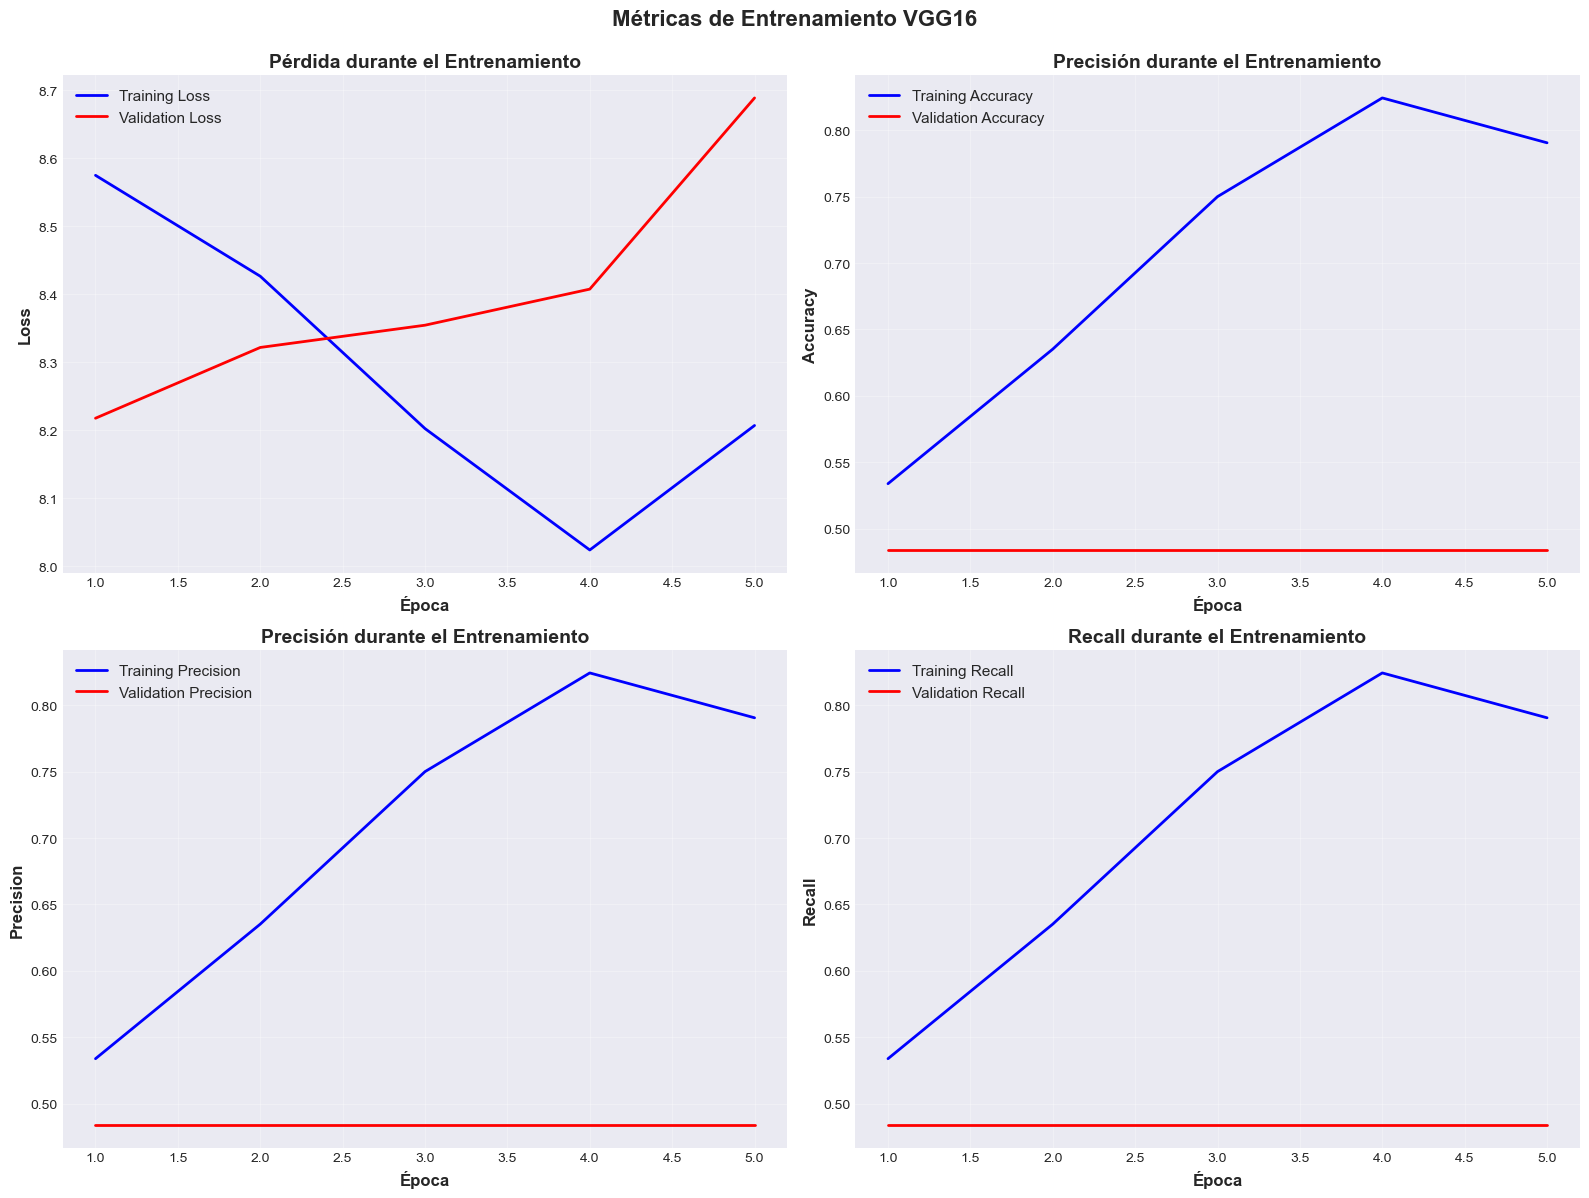


 RESULTADOS FINALES:
  Train Loss:      8.2071
  Val Loss:        8.6885
  Train Accuracy:  0.7905
  Val Accuracy:    0.4839
  Train Precision: 0.7905
  Val Precision:   0.4839
  Train Recall:    0.7905
  Val Recall:      0.4839


In [8]:

print("\n" + "="*70)
print("VISUALIZACIÓN DEL ENTRENAMIENTO")
print("="*70)

# Extraer métricas
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_prec = history.history['precision']
val_prec = history.history['val_precision']
train_rec = history.history['recall']
val_rec = history.history['val_recall']

epochs_range = range(1, len(train_loss) + 1)

# Visualizar
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(epochs_range, train_loss, 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].set_xlabel('Época', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontweight='bold', fontsize=12)
axes[0, 0].set_title('Pérdida durante el Entrenamiento', fontweight='bold', fontsize=14)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(epochs_range, train_acc, 'b-', label='Training Accuracy', linewidth=2)
axes[0, 1].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Época', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontweight='bold', fontsize=12)
axes[0, 1].set_title('Precisión durante el Entrenamiento', fontweight='bold', fontsize=14)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(epochs_range, train_prec, 'b-', label='Training Precision', linewidth=2)
axes[1, 0].plot(epochs_range, val_prec, 'r-', label='Validation Precision', linewidth=2)
axes[1, 0].set_xlabel('Época', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontweight='bold', fontsize=12)
axes[1, 0].set_title('Precisión durante el Entrenamiento', fontweight='bold', fontsize=14)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(epochs_range, train_rec, 'b-', label='Training Recall', linewidth=2)
axes[1, 1].plot(epochs_range, val_rec, 'r-', label='Validation Recall', linewidth=2)
axes[1, 1].set_xlabel('Época', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('Recall', fontweight='bold', fontsize=12)
axes[1, 1].set_title('Recall durante el Entrenamiento', fontweight='bold', fontsize=14)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Métricas de Entrenamiento VGG16', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'training_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()

# Estadísticas finales
print(f"\n RESULTADOS FINALES:")
print(f"  Train Loss:      {train_loss[-1]:.4f}")
print(f"  Val Loss:        {val_loss[-1]:.4f}")
print(f"  Train Accuracy:  {train_acc[-1]:.4f}")
print(f"  Val Accuracy:    {val_acc[-1]:.4f}")
print(f"  Train Precision: {train_prec[-1]:.4f}")
print(f"  Val Precision:   {val_prec[-1]:.4f}")
print(f"  Train Recall:    {train_rec[-1]:.4f}")
print(f"  Val Recall:      {val_rec[-1]:.4f}")

"""
## EVALUACIÓN DEL MODELO

### Matriz de Confusión
Muestra la distribución de predicciones correctas e incorrectas:

```
                    Predicho
                  Clase 0  Clase 1
Real   Clase 0      TP       FN
       Clase 1      FP       TN
```

### Métricas derivadas:
- **Accuracy** = (TP + TN) / Total
- **Precision** = TP / (TP + FP)
- **Recall** = TP / (TP + FN)
- **F1-Score** = 2 × (Precision × Recall) / (Precision + Recall)


"""

In [9]:

print("\n" + "="*70)
print("EVALUACIÓN EN CONJUNTO DE TEST")
print("="*70)

# Predicciones en test set
print("\nGenerando predicciones en test set...")
y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener labels verdaderos
y_true = []
for i in range(len(test_gen)):
    _, batch_labels = test_gen[i]
    y_true.extend(np.argmax(batch_labels, axis=1))
y_true = np.array(y_true[:len(y_pred)])

# Calcular métricas
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='binary')
test_recall = recall_score(y_true, y_pred, average='binary')
test_f1 = f1_score(y_true, y_pred, average='binary')

print(f"\nMÉTRICAS EN TEST SET:")
print(f"  Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

# Classification Report
print("\n" + "="*70)
print("REPORTE DE CLASIFICACIÓN DETALLADO")
print("="*70)
class_names = list(REVERSE_LABEL_MAP.values())
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


EVALUACIÓN EN CONJUNTO DE TEST

Generando predicciones en test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step

MÉTRICAS EN TEST SET:
  Accuracy:  0.4545 (45.45%)
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

REPORTE DE CLASIFICACIÓN DETALLADO
                    precision    recall  f1-score   support

   Natalie Portman     0.4545    1.0000    0.6250        15
Scarlett Johansson     0.0000    0.0000    0.0000        18

          accuracy                         0.4545        33
         macro avg     0.2273    0.5000    0.3125        33
      weighted avg     0.2066    0.4545    0.2841        33




MATRIZ DE CONFUSIÓN


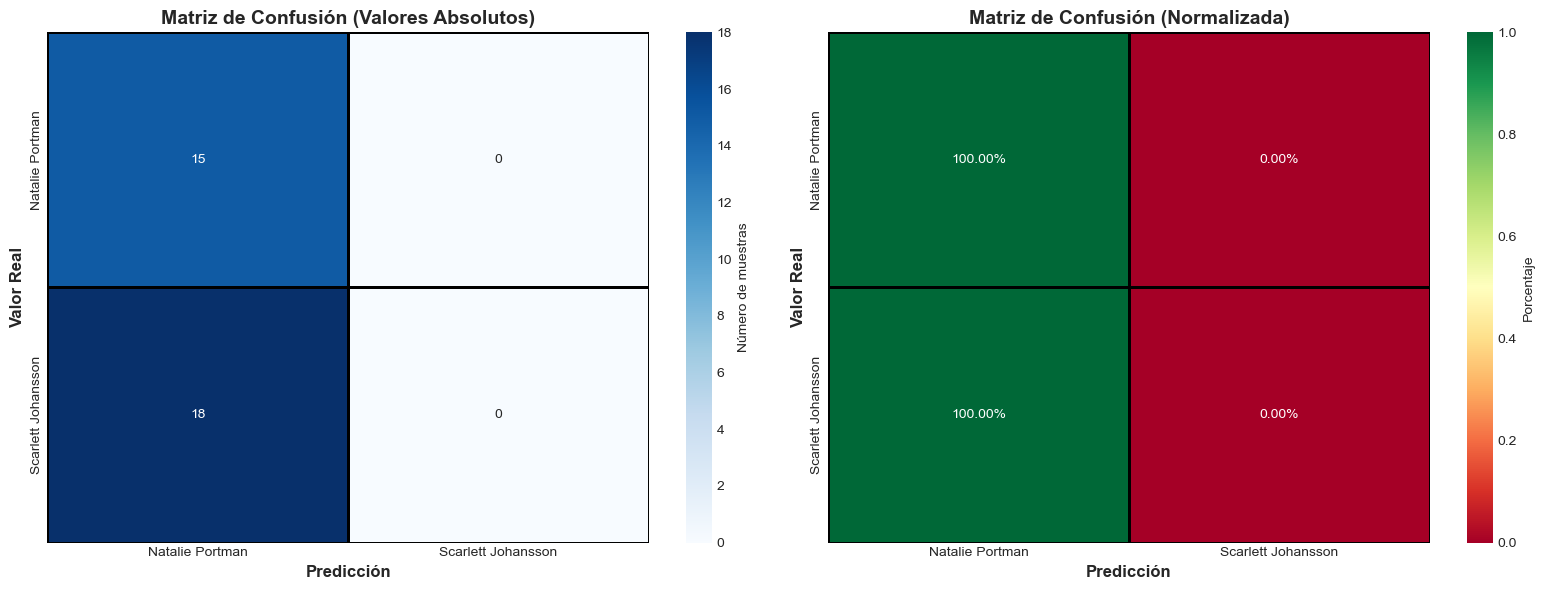


 ANÁLISIS DE LA MATRIZ DE CONFUSIÓN:

Verdaderos Positivos (TP):  15 (Natalie Portman)
Falsos Negativos (FN):      0 (Natalie Portman predicho como Scarlett Johansson)
Falsos Positivos (FP):      18 (Scarlett Johansson predicho como Natalie Portman)
Verdaderos Negativos (TN):  0 (Scarlett Johansson)

Clase 'Natalie Portman':
  Accuracy: 100.00%
  Error:    0.00%

Clase 'Scarlett Johansson':
  Accuracy: 0.00%
  Error:    100.00%


In [10]:

print("\n" + "="*70)
print("MATRIZ DE CONFUSIÓN")
print("="*70)

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualización detallada
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz con valores absolutos
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar_kws={'label': 'Número de muestras'},
            linewidths=2, linecolor='black')
axes[0].set_xlabel('Predicción', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Valor Real', fontweight='bold', fontsize=12)
axes[0].set_title('Matriz de Confusión (Valores Absolutos)', 
                  fontweight='bold', fontsize=14)

# Matriz normalizada (porcentajes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Porcentaje'},
            linewidths=2, linecolor='black', vmin=0, vmax=1)
axes[1].set_xlabel('Predicción', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Valor Real', fontweight='bold', fontsize=12)
axes[1].set_title('Matriz de Confusión (Normalizada)', 
                  fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Análisis de la matriz
print("\n ANÁLISIS DE LA MATRIZ DE CONFUSIÓN:")
print(f"\nVerdaderos Positivos (TP):  {cm[0, 0]} ({class_names[0]})")
print(f"Falsos Negativos (FN):      {cm[0, 1]} ({class_names[0]} predicho como {class_names[1]})")
print(f"Falsos Positivos (FP):      {cm[1, 0]} ({class_names[1]} predicho como {class_names[0]})")
print(f"Verdaderos Negativos (TN):  {cm[1, 1]} ({class_names[1]})")

# Tasa de error por clase
for i, class_name in enumerate(class_names):
    class_accuracy = cm[i, i] / cm[i].sum()
    class_error = 1 - class_accuracy
    print(f"\nClase '{class_name}':")
    print(f"  Accuracy: {class_accuracy:.2%}")
    print(f"  Error:    {class_error:.2%}")


CURVA ROC Y AUC

 AUC Score: 0.4481


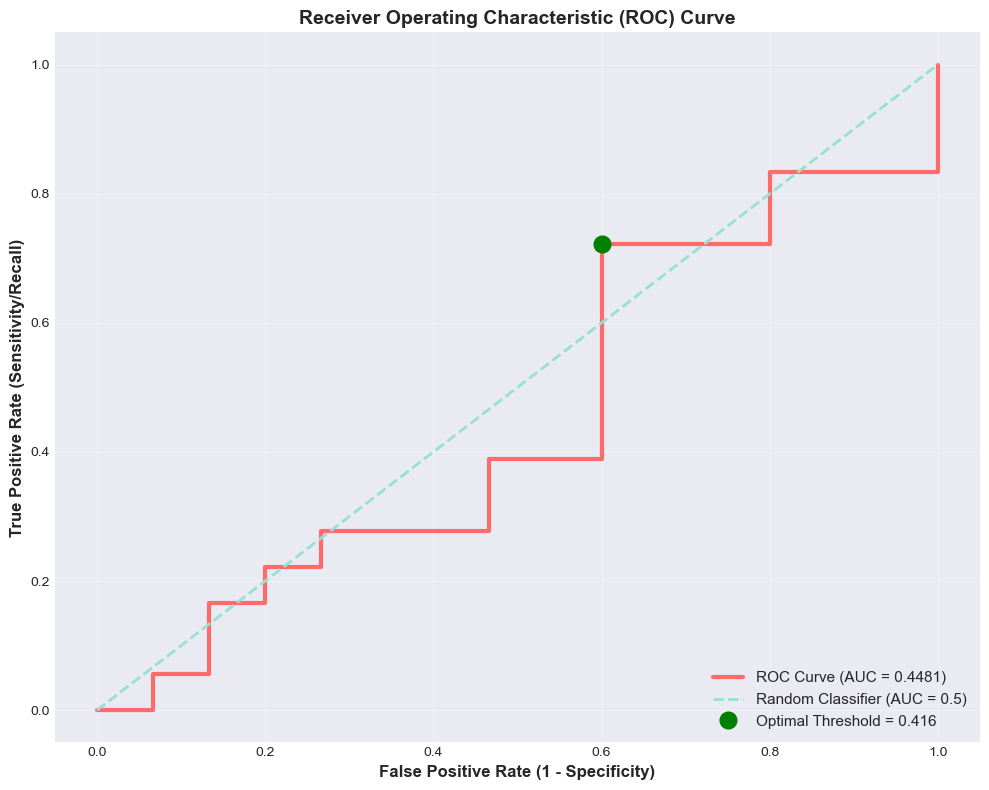


 ANÁLISIS DEL THRESHOLD ÓPTIMO:
  Threshold óptimo: 0.4159
  TPR (Recall):     0.7222
  FPR:              0.6000
  Specificity:      0.4000


In [11]:

print("\n" + "="*70)
print("CURVA ROC Y AUC")
print("="*70)

# Calcular ROC para clasificación binaria
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

print(f"\n AUC Score: {roc_auc:.4f}")

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))

# Curva ROC
ax.plot(fpr, tpr, color='#FF6B6B', linewidth=3, 
        label=f'ROC Curve (AUC = {roc_auc:.4f})')

# Línea diagonal (clasificador aleatorio)
ax.plot([0, 1], [0, 1], color='#95E1D3', linewidth=2, 
        linestyle='--', label='Random Classifier (AUC = 0.5)')

# Punto óptimo (Youden's index)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
ax.plot(fpr[optimal_idx], tpr[optimal_idx], 'go', markersize=12, 
        label=f'Optimal Threshold = {optimal_threshold:.3f}')

ax.set_xlabel('False Positive Rate (1 - Specificity)', 
              fontweight='bold', fontsize=12)
ax.set_ylabel('True Positive Rate (Sensitivity/Recall)', 
              fontweight='bold', fontsize=12)
ax.set_title('Receiver Operating Characteristic (ROC) Curve', 
             fontweight='bold', fontsize=14)
ax.legend(fontsize=11, loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'roc_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

# Análisis del threshold óptimo
print(f"\n ANÁLISIS DEL THRESHOLD ÓPTIMO:")
print(f"  Threshold óptimo: {optimal_threshold:.4f}")
print(f"  TPR (Recall):     {tpr[optimal_idx]:.4f}")
print(f"  FPR:              {fpr[optimal_idx]:.4f}")
print(f"  Specificity:      {1 - fpr[optimal_idx]:.4f}")

"""
## ANÁLISIS DE ERROR

### Objetivos:
1. **Identificar patrones** en predicciones incorrectas
2. **Visualizar casos difíciles** para el modelo
3. **Entender limitaciones** del modelo
4. **Proponer mejoras** basadas en los errores

### Tipos de errores:
- **Falsos Positivos**: Modelo predice clase 1, pero es clase 0
- **Falsos Negativos**: Modelo predice clase 0, pero es clase 1

### Análisis cualitativo:
- ¿Qué características comparten los errores?
- ¿Hay problemas de calidad de imagen?
- ¿Existen poses o ángulos problemáticos?
"""


ANÁLISIS DE ERRORES

 DISTRIBUCIÓN DE ERRORES:
  Total de muestras:      33
  Predicciones correctas: 15 (45.45%)
  Predicciones erróneas:  18 (54.55%)

 TIPOS DE ERROR:
  Falsos Positivos (FP):  18
    Real: Scarlett Johansson → Predicho: Natalie Portman
  Falsos Negativos (FN):  0
    Real: Natalie Portman → Predicho: Scarlett Johansson

 ANÁLISIS DE CONFIANZA:
  Confianza promedio en predicciones correctas: 0.5840
  Confianza promedio en errores:                0.5840
  Diferencia:                                   -0.0000


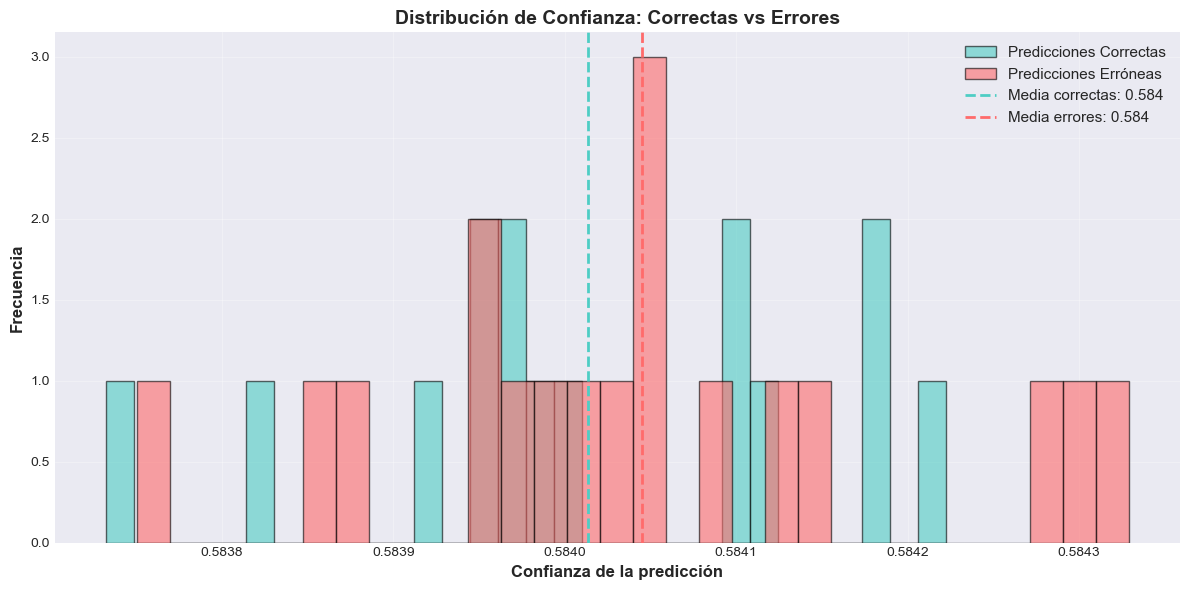

In [12]:

print("\n" + "="*70)
print("ANÁLISIS DE ERRORES")
print("="*70)

# Identificar errores
errors = y_true != y_pred
error_indices = np.where(errors)[0]
correct_indices = np.where(~errors)[0]

print(f"\n DISTRIBUCIÓN DE ERRORES:")
print(f"  Total de muestras:      {len(y_true)}")
print(f"  Predicciones correctas: {len(correct_indices)} ({len(correct_indices)/len(y_true)*100:.2f}%)")
print(f"  Predicciones erróneas:  {len(error_indices)} ({len(error_indices)/len(y_true)*100:.2f}%)")

# Clasificar errores por tipo
false_positives = []
false_negatives = []

for idx in error_indices:
    if y_true[idx] == 0 and y_pred[idx] == 1:
        false_negatives.append(idx)
    elif y_true[idx] == 1 and y_pred[idx] == 0:
        false_positives.append(idx)

print(f"\n TIPOS DE ERROR:")
print(f"  Falsos Positivos (FP):  {len(false_positives)}")
print(f"    Real: {class_names[1]} → Predicho: {class_names[0]}")
print(f"  Falsos Negativos (FN):  {len(false_negatives)}")
print(f"    Real: {class_names[0]} → Predicho: {class_names[1]}")

# Análisis de confianza en errores
error_confidences = []
correct_confidences = []

for idx in error_indices:
    confidence = y_pred_probs[idx, y_pred[idx]]
    error_confidences.append(confidence)

for idx in correct_indices:
    confidence = y_pred_probs[idx, y_pred[idx]]
    correct_confidences.append(confidence)

print(f"\n ANÁLISIS DE CONFIANZA:")
print(f"  Confianza promedio en predicciones correctas: {np.mean(correct_confidences):.4f}")
print(f"  Confianza promedio en errores:                {np.mean(error_confidences):.4f}")
print(f"  Diferencia:                                   {np.mean(correct_confidences) - np.mean(error_confidences):.4f}")

# Visualización de distribución de confianza
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(correct_confidences, bins=30, alpha=0.6, label='Predicciones Correctas', 
        color='#4ECDC4', edgecolor='black')
ax.hist(error_confidences, bins=30, alpha=0.6, label='Predicciones Erróneas', 
        color='#FF6B6B', edgecolor='black')

ax.axvline(np.mean(correct_confidences), color='#4ECDC4', linestyle='--', 
           linewidth=2, label=f'Media correctas: {np.mean(correct_confidences):.3f}')
ax.axvline(np.mean(error_confidences), color='#FF6B6B', linestyle='--', 
           linewidth=2, label=f'Media errores: {np.mean(error_confidences):.3f}')

ax.set_xlabel('Confianza de la predicción', fontweight='bold', fontsize=12)
ax.set_ylabel('Frecuencia', fontweight='bold', fontsize=12)
ax.set_title('Distribución de Confianza: Correctas vs Errores', 
             fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'confidence_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()


VISUALIZACIÓN DE CASOS DE ERROR

 Visualizando Falsos Positivos...


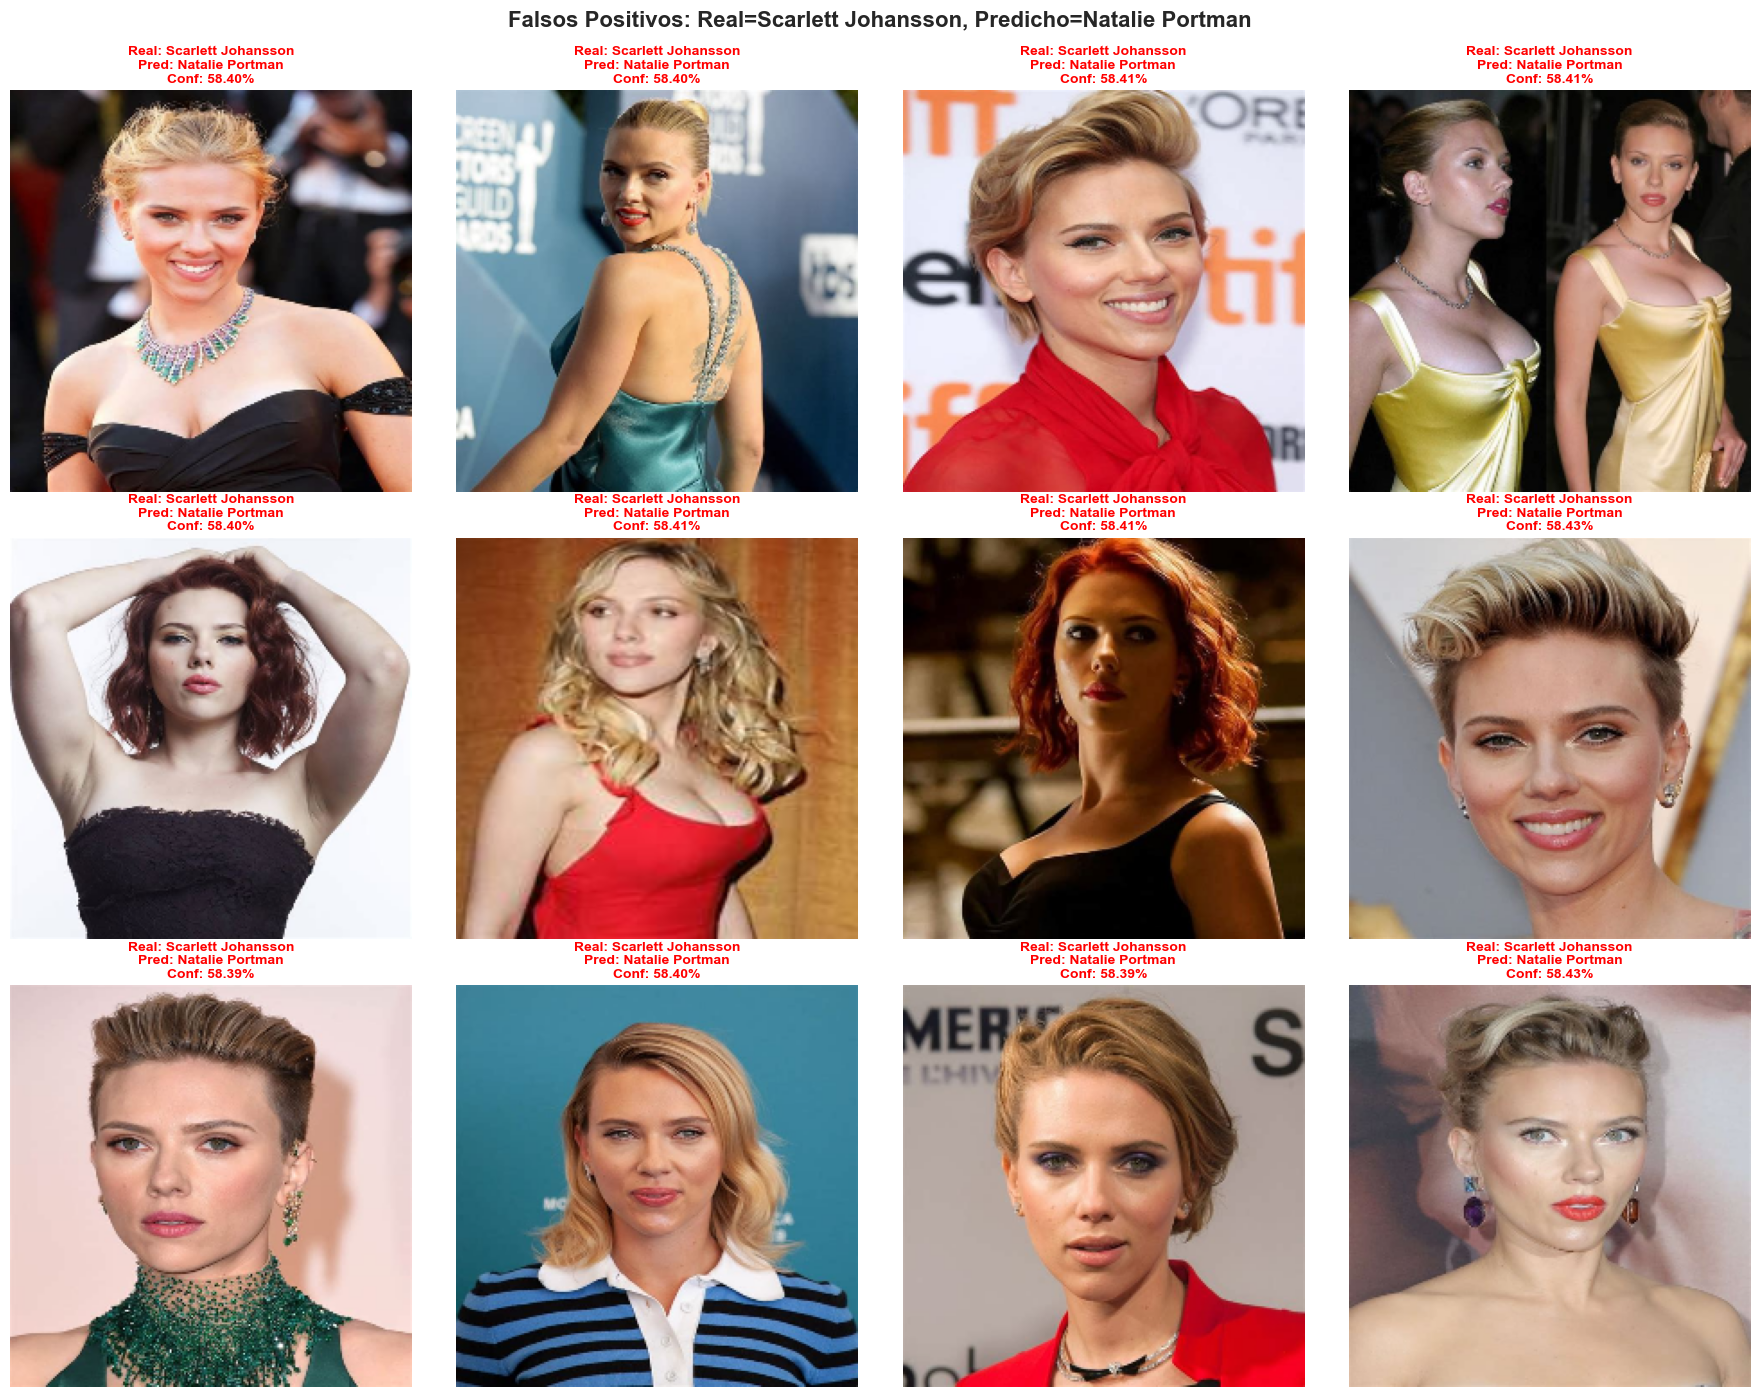


 Visualizando Predicciones Correctas (Alta Confianza)...


In [13]:

print("\n" + "="*70)
print("VISUALIZACIÓN DE CASOS DE ERROR")
print("="*70)

def visualize_predictions(indices, y_true, y_pred, y_pred_probs, test_df, 
                         title, num_samples=12):
    """Visualiza muestras con sus predicciones"""
    num_samples = min(num_samples, len(indices))
    selected_indices = np.random.choice(indices, num_samples, replace=False)
    
    rows = 3
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(18, 14))
    axes = axes.ravel()
    
    for i, idx in enumerate(selected_indices):
        # Cargar imagen original
        img_path = test_df.iloc[idx]['paths']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        
        # Información
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        confidence = y_pred_probs[idx, y_pred[idx]]
        
        # Mostrar
        axes[i].imshow(img)
        
        # Color del título según si es correcto o no
        is_correct = y_true[idx] == y_pred[idx]
        color = 'green' if is_correct else 'red'
        
        axes[i].set_title(
            f'Real: {true_label}\n'
            f'Pred: {pred_label}\n'
            f'Conf: {confidence:.2%}',
            fontweight='bold',
            color=color,
            fontsize=10
        )
        axes[i].axis('off')
    
    # Ocultar ejes vacíos
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    return fig

# Visualizar falsos positivos
if len(false_positives) > 0:
    print("\n Visualizando Falsos Positivos...")
    fig_fp = visualize_predictions(
        false_positives, y_true, y_pred, y_pred_probs, test_df,
        f'Falsos Positivos: Real={class_names[1]}, Predicho={class_names[0]}'
    )
    fig_fp.savefig(os.path.join(RESULTS_DIR, 'false_positives.png'), 
                   dpi=300, bbox_inches='tight')
    plt.show()

# Visualizar falsos negativos
if len(false_negatives) > 0:
    print("\n Visualizando Falsos Negativos...")
    fig_fn = visualize_predictions(
        false_negatives, y_true, y_pred, y_pred_probs, test_df,
        f'Falsos Negativos: Real={class_names[0]}, Predicho={class_names[1]}'
    )
    fig_fn.savefig(os.path.join(RESULTS_DIR, 'false_negatives.png'), 
                   dpi=300, bbox_inches='tight')
    plt.show()

# Visualizar predicciones correctas con alta confianza
print("\n Visualizando Predicciones Correctas (Alta Confianza)...")
high_conf_correct = [idx for idx in correct_indices 
                    if y_pred_probs[idx, y_pred[idx]] > 0.95]
if len(high_conf_correct) > 0:
    fig_correct = visualize_predictions(
        high_conf_correct[:12], y_true, y_pred, y_pred_probs, test_df,
        'Predicciones Correctas con Alta Confianza (>95%)'
    )
    fig_correct.savefig(os.path.join(RESULTS_DIR, 'high_confidence_correct.png'), 
                       dpi=300, bbox_inches='tight')
    plt.show()


In [17]:

print("\n" + "="*70)
print("GUARDANDO MODELO Y RESULTADOS")
print("="*70)

# Guardar modelo completo
model_path = os.path.join(MODEL_SAVE_DIR, 'vgg16_final_model.keras')
model.save(model_path)
print(f" Modelo guardado en: {model_path}")

# Guardar modelo en formato TensorFlow SavedModel (para producción)
saved_model_path = os.path.join(MODEL_SAVE_DIR, 'vgg16_saved_model')
model.save(saved_model_path, save_format='tf')
print(f" SavedModel guardado en: {saved_model_path}")

# Guardar solo los pesos
weights_path = os.path.join(MODEL_SAVE_DIR, 'vgg16_weights.h5')
model.save_weights(weights_path)
print(f"✓ Pesos guardados en: {weights_path}")

# Guardar resultados en JSON
results = {
    'model_name': 'VGG16_Custom',
    'num_parameters': int(total_params),
    'training': {
        'epochs_trained': len(train_loss),
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'final_train_loss': float(train_loss[-1]),
        'final_val_loss': float(val_loss[-1]),
        'final_train_accuracy': float(train_acc[-1]),
        'final_val_accuracy': float(val_acc[-1])
    },
    'test_metrics': {
        'accuracy': float(test_accuracy),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'f1_score': float(test_f1),
        'auc': float(roc_auc)
    },
    'confusion_matrix': cm.tolist(),
    'error_analysis': {
        'total_errors': int(len(error_indices)),
        'false_positives': int(len(false_positives)),
        'false_negatives': int(len(false_negatives)),
        'avg_confidence_correct': float(np.mean(correct_confidences)),
        'avg_confidence_errors': float(np.mean(error_confidences))
    },
    'classes': class_names,
    'label_map': LABEL_MAP
}

results_path = os.path.join(RESULTS_DIR, 'model_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)
print(f" Resultados guardados en: {results_path}")

print("\n Todos los archivos guardados correctamente!")

print("\n" + "="*70)
print("ENTRENAMIENTO Y EVALUACIÓN COMPLETADOS")


GUARDANDO MODELO Y RESULTADOS


MemoryError: Unable to allocate 392. MiB for an array with shape (25088, 4096) and data type float32